In [52]:
#Import Dependencies
import numpy as np
import h5py
import matplotlib.pyplot as plt

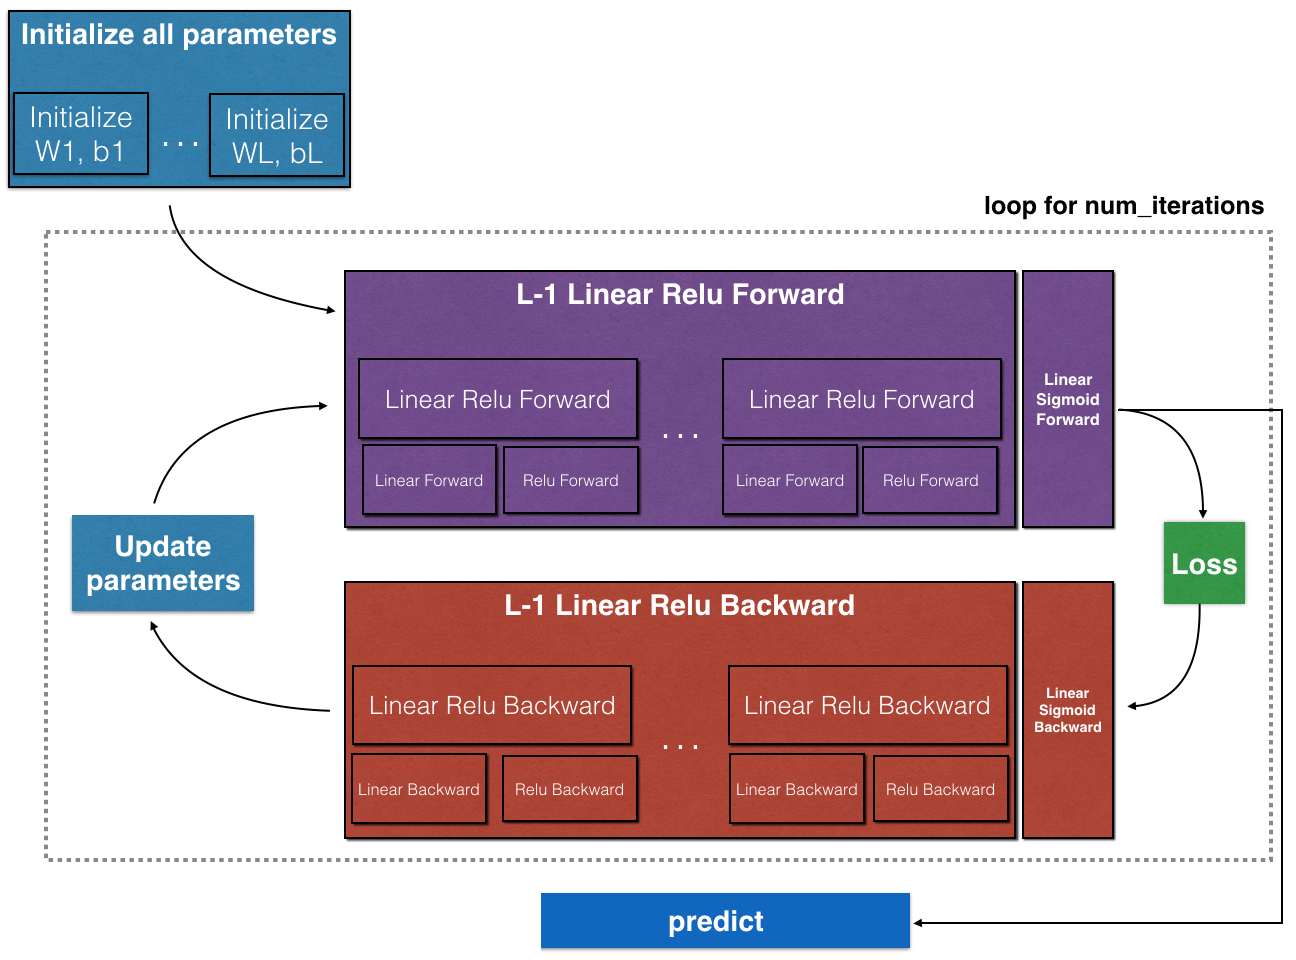

The model's structure is Linear -> ReLU -> Linear -> Sigmoid

In [53]:
#----- Initialize parameters for a deep neural network -----
def initialize_parameters_deep(layer_dims):
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [69]:
#----- Activation functions ------

# ReLU function
def relu(Z):
    A = np.maximum(0,Z)
    cache = Z 
    
    return A, cache


# Sigmoid function 
def sigmoid(Z):
   A = 1 / ( 1 + np.exp(-Z))
   
   cache = Z
   return A, cache 

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}$$


In [55]:
#----- Forward propogation helper functions -----

# Forward prop of linear function
def linear_forward(A,W,b):
  Z = np.dot(W,A) + b
  cache = (A,W,b)
  
  return Z, cache



**Sigmoid**: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$. 

**ReLU**: The mathematical formula for ReLu is $A = RELU(Z) = max(0, Z)$. 

In [83]:
# Forward prop of Linear -> Activation
def linear_activation_forward(A_prev, W, b, activation):

  if activation =='sigmoid':
    Z, linear_cache = linear_forward(A_prev, W, b)
    A, activation_cache = sigmoid((Z))

  elif activation == 'relu':
    Z, linear_cache = linear_forward(A_prev, W, b)
    A, activation_cache = relu(Z)

  cache = (linear_cache, activation_cache)
  return A, cache

In [57]:
# L-model forward 

def L_model_forward(X, parameters):
    caches = []
    A = X # input layer
    L = len(parameters) // 2   #number of layers
  
    for l in range(1, L):
        A_prev = A # starts with A = X then ends with A[L]
        A, cache = linear_activation_forward(A_prev, parameters['W'+ str(l)], parameters['b'+str(l)], 'relu') # Hidden layers
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], 'sigmoid') # Last layer. Sigmoid Activation
    caches.append(cache)

       
    return AL, caches

Compute the cross-entropy cost $J$, using the following formula: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$

In [81]:
 # Compute Cost

def compute_cost(AL, Y):
    m = Y.shape[1]

    epsilon = 1e-8
    cost = -(1 / m) * np.sum((Y * np.log(AL + epsilon) + (1 - Y) * np.log(1 - AL + epsilon)), axis=1, keepdims=True)

    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

Now that we have completed the forward propagation helper functions, we need to do the same for the backward propagation functions.


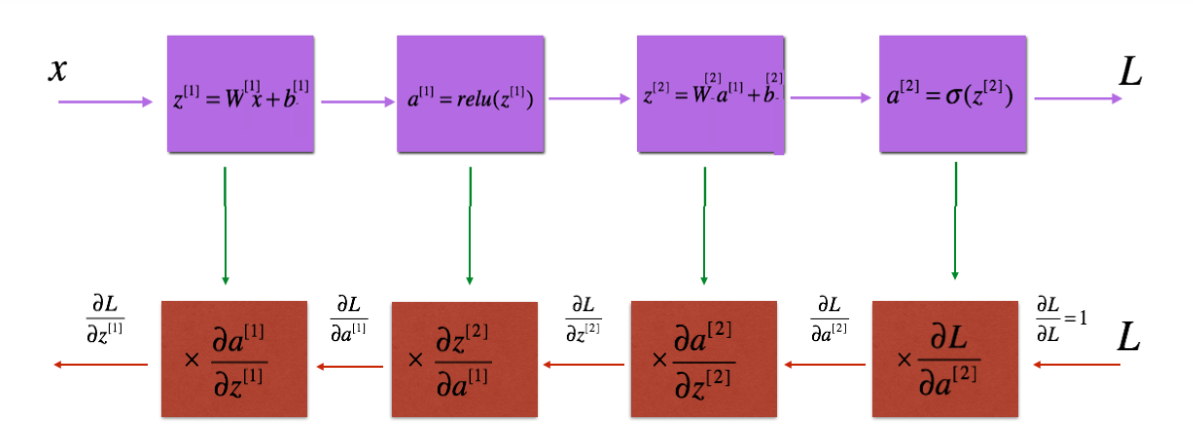

We need to compute helper functions for:
  - Linear Backward
  - Linear-Activation backward
  - L-model backward

The equations we need for the Linear Backward are:
$$ dW^{[l]} = \frac{\partial \mathcal{J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} $$
$$ db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} $$




In [71]:
 #----- Backward Propagation helper functions ------

# Linear Backward
def linear_backward(dZ, cache):

    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
  
    
    return dA_prev, dW, db

In [60]:
# Linear-Activation backward

# Actiavtion backward helper function for relu
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.

    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    
    return dZ

# Actiavtion backward helper function for sigmoid
def sigmoid_backward(dA, cache):
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
        
    return dZ

def linear_activation_backward(dA, cache, activation):
  
    linear_cache, activation_cache = cache
    
    # backward operation per activation
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
      
    elif activation == "sigmoid":  
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
        
    
    return dA_prev, dW, db

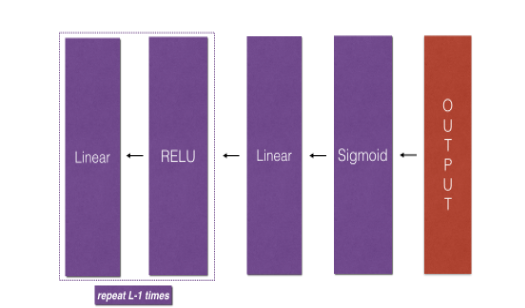

In [61]:
# L_model_backward

def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    dAL = - (np.divide(Y,AL) - np.divide(1 - Y, 1- AL))
    

    current_cache = caches[L-1] # Last Layer
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")
    
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

Finally, we need a helper function for updating our parameters and performing Gradient Descent.

In [62]:
# update_parameters

def update_parameters(params, grads, learning_rate):
    parameters = params.copy()
    L = len(parameters) // 2 

    for l in range(L):     
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]   

    return parameters


---


**Now that we created the essential functions for a Deep layer neural network, we will use this to train on images and classify whether the image is a cat or not.**
---






In [63]:
#----- Load the dataset -----
def load_data():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

y = 0. It's a non-cat picture.


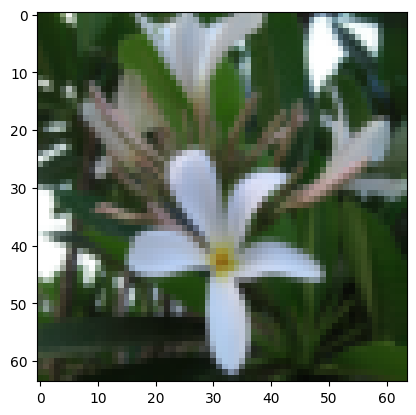

In [64]:
#----- Load the dataset, visualize, and identify shape -----
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

index = 9
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")



In [65]:
# Explore the dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [66]:
#----- Data preprocessing -----

# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


In [87]:
# Set up constants
layers_dims = [12288, 20, 7, 5, 1]


# Define model
def model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
 

    costs = []          # keep track of cost
    
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)
        
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
   
        # Compute cost.
        cost = compute_cost(AL, Y)
        
        # Backward propagation.
        grads = L_model_backward(AL,Y,caches)
      
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    
    return parameters, costs

In [88]:
parameters, costs = model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

Cost after iteration 0: 0.7168090971679449
Cost after iteration 100: 0.6593483618216573
Cost after iteration 200: 0.6008021517057458
Cost after iteration 300: 0.5360332392579744
Cost after iteration 400: 0.47711428736556155
Cost after iteration 500: 0.41435834524427334
Cost after iteration 600: 0.35492646259792454
Cost after iteration 700: 0.34271424997865035
Cost after iteration 800: 0.17238878647800263
Cost after iteration 900: 0.1148035388902141
Cost after iteration 1000: 0.08814677754236884
Cost after iteration 1100: 0.05608762973215991
Cost after iteration 1200: 0.039443293394968264
Cost after iteration 1300: 0.02893232801166993
Cost after iteration 1400: 0.022083514609307433
Cost after iteration 1500: 0.01739218859866646
Cost after iteration 1600: 0.01405933316636215
Cost after iteration 1700: 0.01160671206556719
Cost after iteration 1800: 0.009754392377389932
Cost after iteration 1900: 0.008336788244125547
Cost after iteration 2000: 0.007226442343757187
Cost after iteration 2100

In [89]:
def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [90]:
# Predict the model with a new dataset

pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.76


In [91]:
def print_mislabeled_images(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))

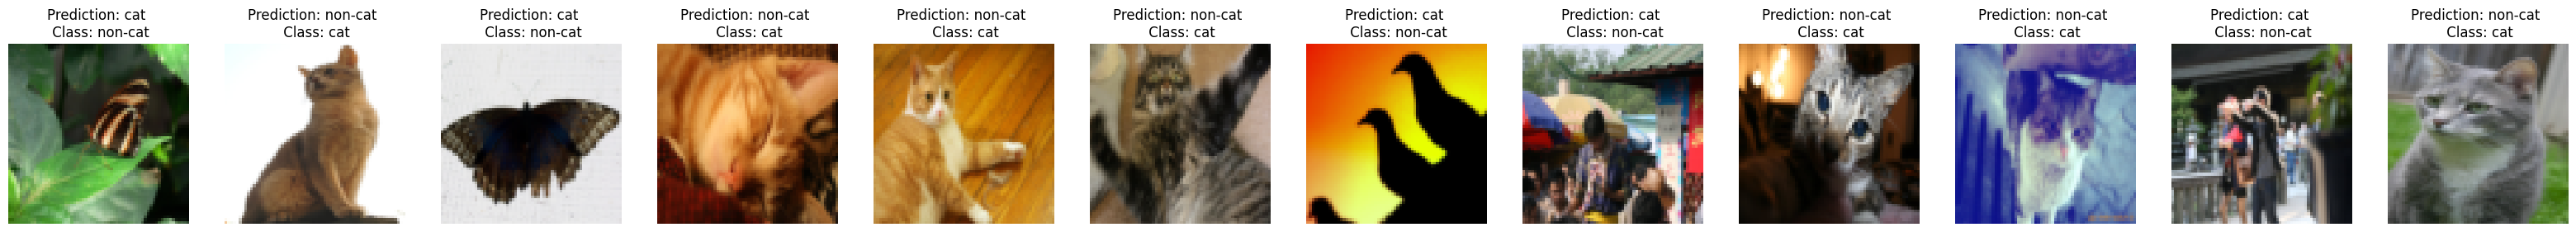

In [92]:
print_mislabeled_images(classes, test_x, test_y, pred_test)